In [1]:
%load_ext autoreload
%autoreload 2

## AGN DCR Metric (View)
This notebook build upon the prototype shown in [DCR_AGN_metric_analysis.ipynb](https://github.com/RichardsGroup/LSSTprep/blob/master/DCR/DCR_AGN_metric_analysis.ipynb) but with a focus on the integration with MAF and provide the ability to use more realistic astrometric errors simulated by OpSim. 

### 0. Software Setup

In [2]:
your_username = 'ywx649999311'

In [38]:
# import matplotlib to show plots inline.wfd_depth_scale0.95_v1.5_10yrs.db
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os

Import the sims_maf modules needed.

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

# import convenience functions
from opsimUtils import *

## 1. Compare DCR metric to desired slopes
### 1.1 Load in simulated DCR data (used to define metric)

In [5]:
# load in data and merge into one df
dcr_data_dir = 'DCR_data/'
dfZ = pd.read_csv(os.path.join(dcr_data_dir, 'fittingS82_zshifts.dat'))
dfQSO = pd.read_csv(os.path.join(dcr_data_dir, 'fittingS82_zshiftfit.dat'), \
                                index_col=0, header=None, sep=' ').T.dropna().reset_index(drop=True)
dfDCR = pd.concat([dfZ, dfQSO], axis=1)
dfDCR.head()

zshifts     u-g     g-r     r-i     i-z  u-slope  g-slope
0     0.40  0.3790  0.1143  0.1995  0.2466   0.0012   0.0258
1     0.45  0.2507  0.0644  0.2651  0.2032   0.0053   0.0506
2     0.50  0.2023  0.0410  0.2679  0.1762   0.0002   0.0589
3     0.55  0.3056  0.0252  0.2351  0.1314  -0.0140   0.0357
4     0.60  0.3419  0.0727  0.1867  0.1570  -0.0083   0.0143

### 1.2 Load in metric results

In [6]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

resultDbPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/0807/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/0807/MetricData/'

In [7]:
# import metric evaluations
bundleDicts = {}

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [11]:
# check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[1]].keys())
print(bd_keys)

[(1, 'DCR_19_g'), (2, 'DCR_21_g'), (3, 'DCR_23_g'), (4, 'DCR_25_g'), (5, 'DCR_19.15_u'), (6, 'DCR_21.15_u'), (7, 'DCR_23.15_u'), (8, 'DCR_25.15_u')]


## 2. Make plots
### 2.1 Histplots

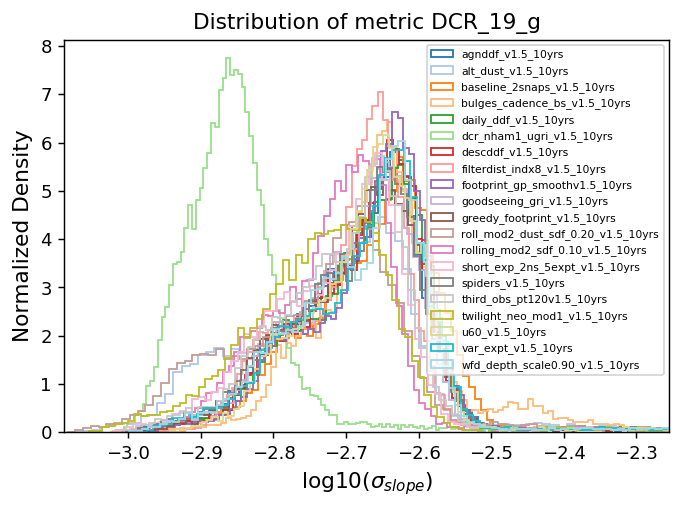

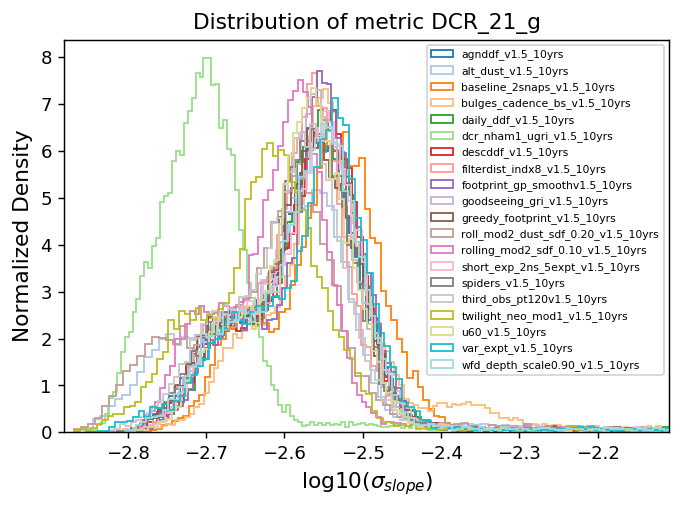

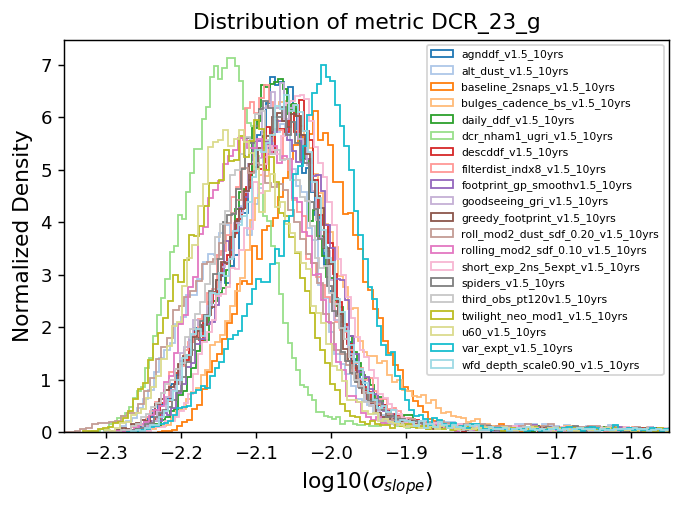

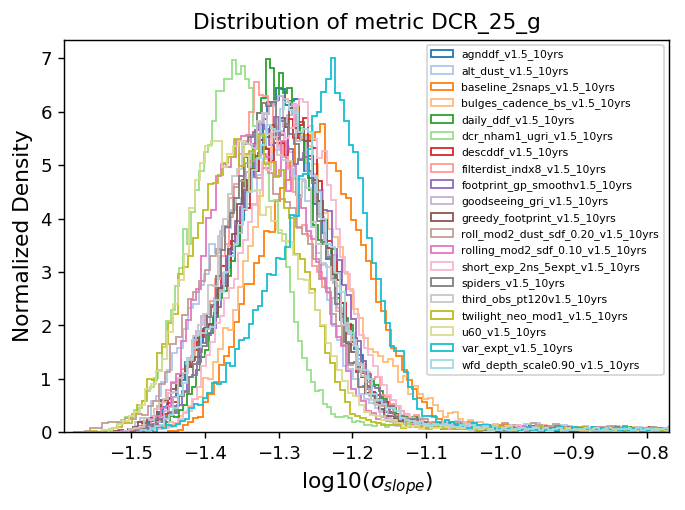

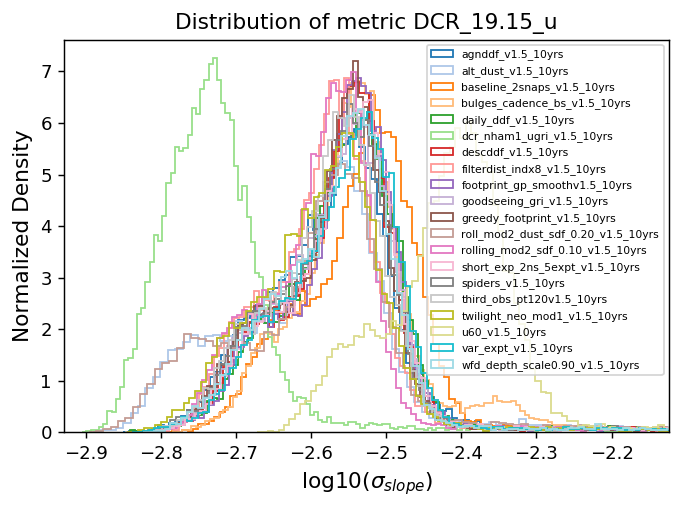

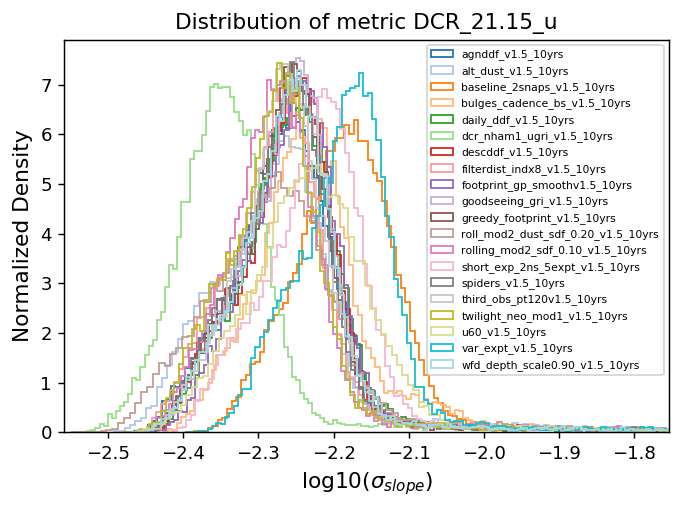

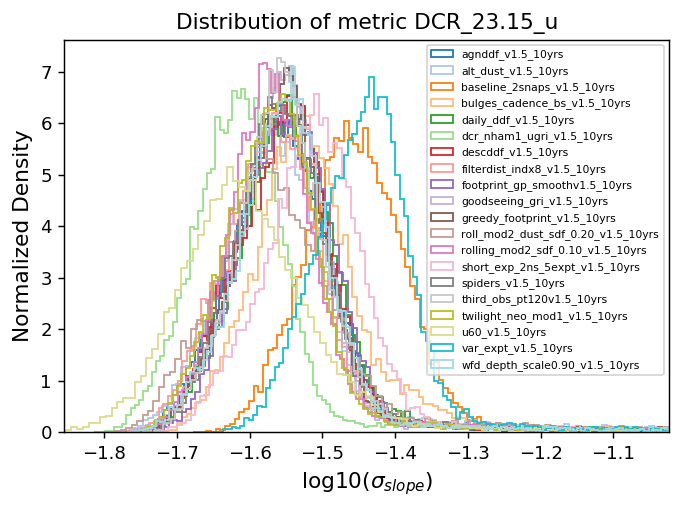

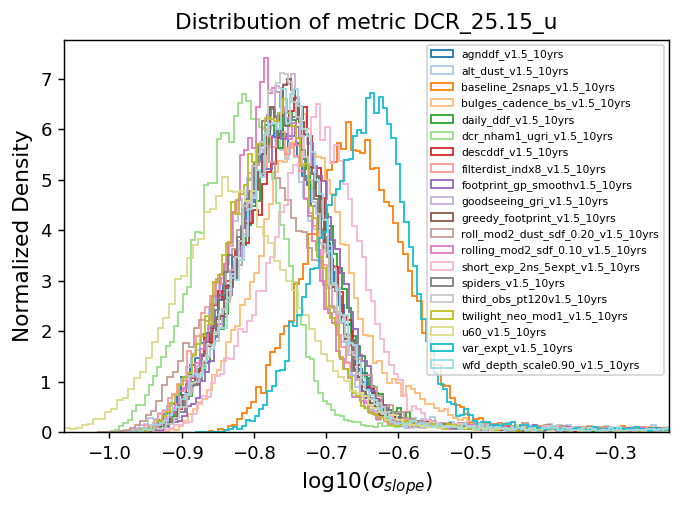

In [44]:
# loop though each metric to make plots, since some values are fairly large 
# and built in functions doesn't allow log scale
for key in bd_keys:
    fig = plt.figure(dpi=130)
    for i, run in enumerate(resultDbsView):
        
        # look for the correct combination of metricID and metricName 
        keys = [*bundleDicts[run].keys()]
        metricKey = [elem for elem in keys if elem[1] == key[1]][0]
        
        # need to mask the pixels that have no available data
        mask = bundleDicts[run][metricKey].metricValues.mask
        data = bundleDicts[run][metricKey].metricValues.data[~mask]

        # plot
        _ = plt.hist(np.log10(data), bins='fd', histtype='step', color=mpl.cm.tab20.colors[i], \
                     density=True, label=f'{run}')
        plt.xlabel('log10($\\sigma_{slope}$)', fontsize=12)
        plt.ylabel('Normalized Density', fontsize=12)
        plt.legend(fontsize=6)
        plt.xlim(right = np.log10(np.percentile(data, 99)))
    
    plt.title(f'Distribution of metric {key[1]}', fontsize=12)

### 2.2 Slope SNR plot
Plots in this section will show the SNR for the slope of the best-fit DCR line. With the SNR defined as:

    SNR = QSO_DCR_slope/slope_uncertainty

Eash figure plot the SNR for twenty different cadence simulations (with each being only in their familiy) and for both u and g bands, given a fixed u-g color of 0.15.

In [65]:
def plot_dcr_snr(mb, dfQSO, **kwargs):
        
    mask = mb.metricValues.mask
    data = mb.metricValues.data[~mask]
    median = np.median(data)
    metricName = mb.metric.name

    if  metricName.split('_')[-1] == 'u':
        slope_col = 'u-slope'
    else:
        slope_col = 'g-slope'

    _ = plt.plot(dfQSO['zshifts'], dfQSO[slope_col]/median, **kwargs)

    plt.xlabel('Redshift', fontsize=12)
    plt.ylabel('Slope SNR', fontsize=12)

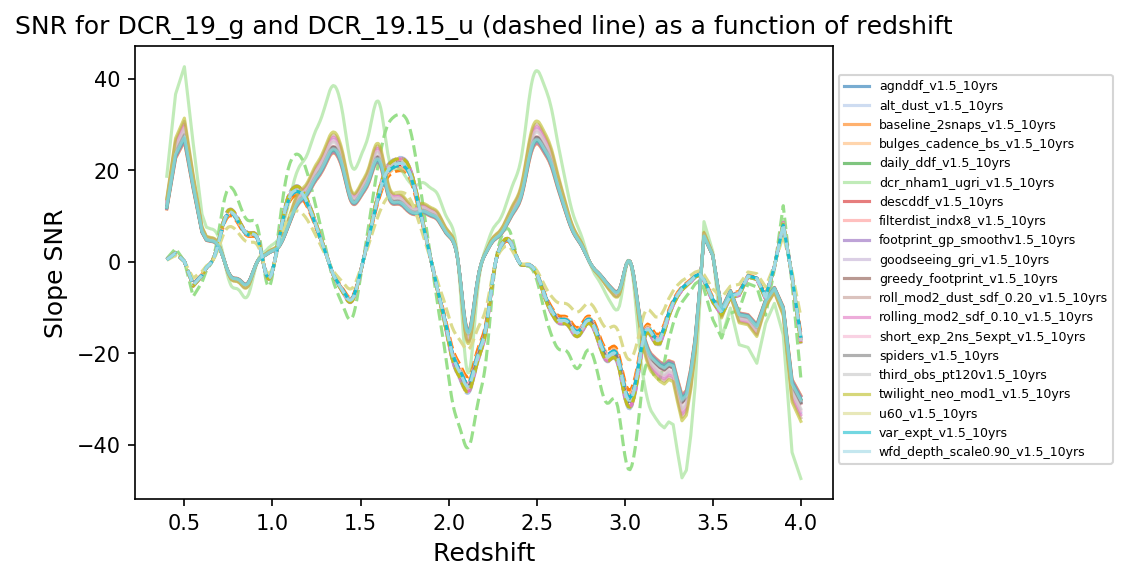

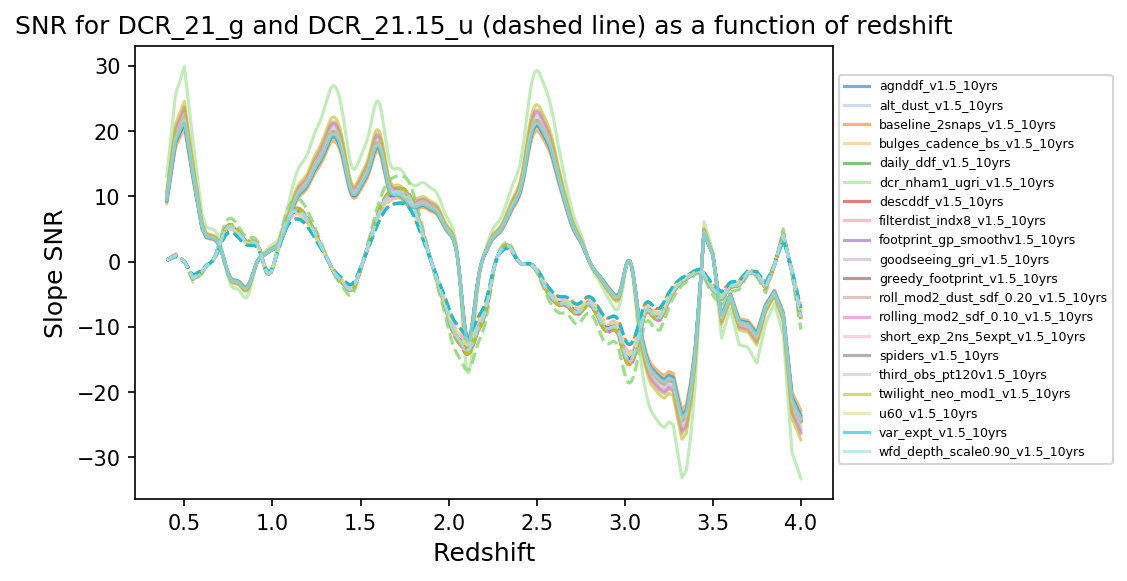

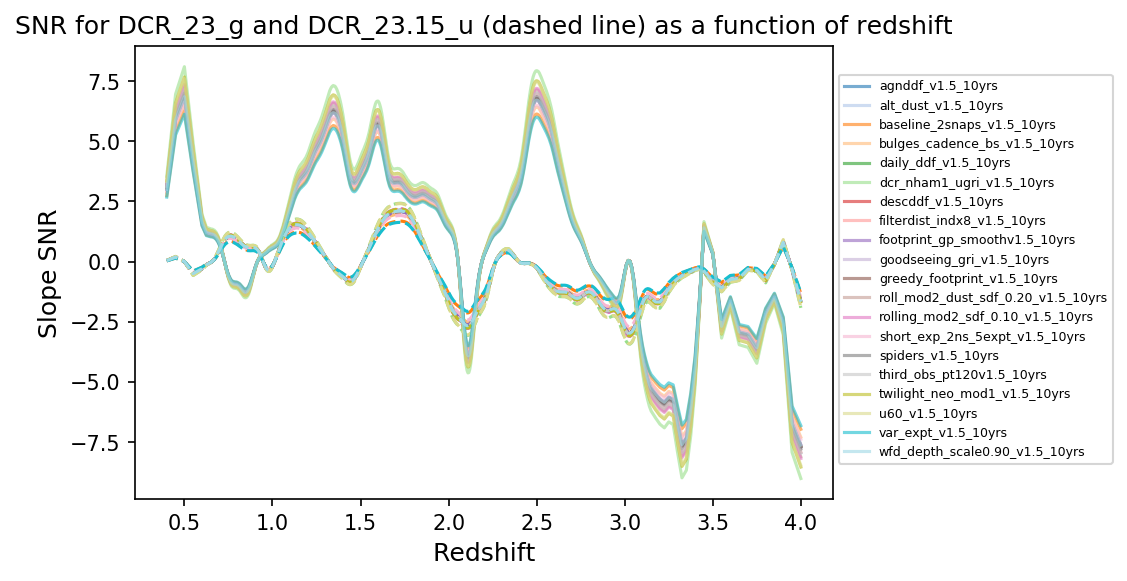

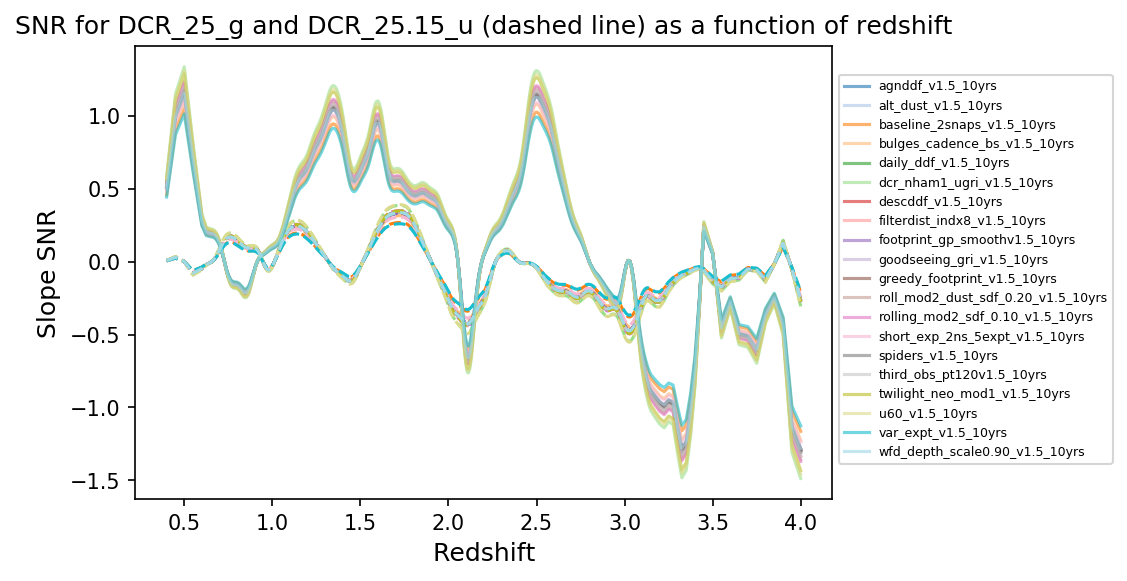

In [75]:
gMags = [19, 21, 23, 25]
for j, key in enumerate(bd_keys):
    
    if j < 4:
        fig = plt.figure(dpi=150)
        for i, run in enumerate(resultDbsView):
            
            uKey = (j+4, f'DCR_{gMags[j]+0.15}_u')
            
            # look for the correct combination of metricID and metricName 
            keys = [*bundleDicts[run].keys()]
            metricKeyG = [elem for elem in keys if elem[1] == key[1]][0]
            metricKeyU = [elem for elem in keys if elem[1] == uKey[1]][0]
            
            plot_dcr_snr(bundleDicts[run][metricKeyG], dfDCR, \
                         color=mpl.cm.tab20.colors[i], alpha=0.6, label=f'{run}')
            plot_dcr_snr(bundleDicts[run][metricKeyU], dfDCR, \
                         color=mpl.cm.tab20.colors[i], linestyle='--', label='')

        plt.legend(fontsize=6, loc='best', bbox_to_anchor=(1., 0.95))
        plt.title(f'SNR for {key[1]} and {uKey[1]} (dashed line) as a function of redshift')

### 2.3 SkyPlots
Show the slope uncertainty over the sky

<!--Didn't find a easy way to plot healpy plot side by side, healpy takes figure as input, not axes. 
Might find better ways in the future-->

In [76]:
# function to make sky plot
import healpy as hp
def plotSky_scale(mb, scale_func=np.log10, **kwargs):
    '''
    Plot High-Res DDF skymap. 
    Args:
        mb: MetricBundle object.
        ddfName(str): The string name of the DDF field, e.g., COSMOS.
        xsize(int): The dimention of the plot in pixels, default is 250 pixels.
        scale (func): A scaling function for the metric data, e.g., np.log10
    '''
    

    try:
        mbValues = mb.metricValues.copy()
        mask = mbValues.mask
        data = mbValues.data[~mask]
        nData = scale_func(data)
    except Exception as e:
        print(e)
        return None
    else:
        mbValues.data[~mask] = nData
        maxVal = np.percentile(nData, 99)

        _ = hp.mollview(mbValues, flip='astro', max=maxVal, **kwargs)

    _ = hp.graticule(dpar=30, dmer=30, verbose=False)
    plt.title(f'Metric:{mb.metric.name}, RunName:{mb.runName}', fontsize=15)

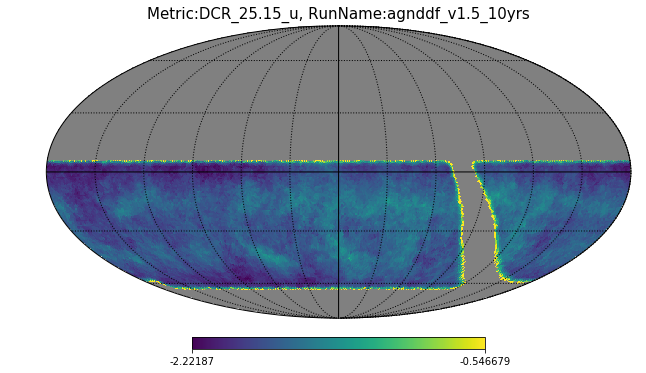

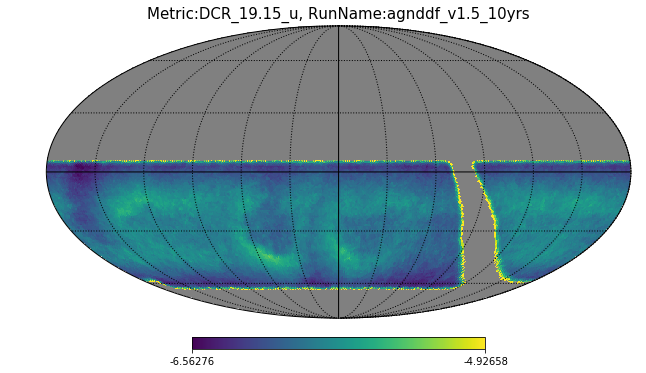

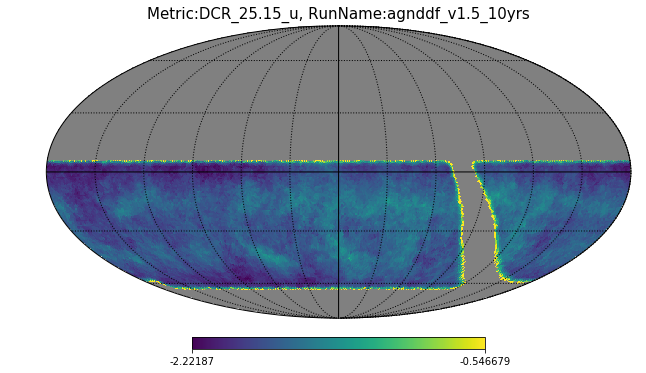

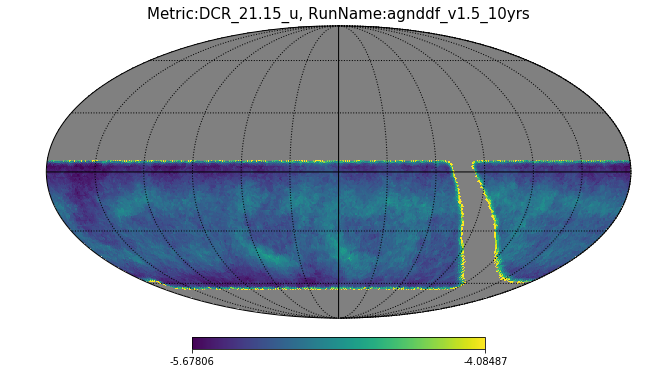

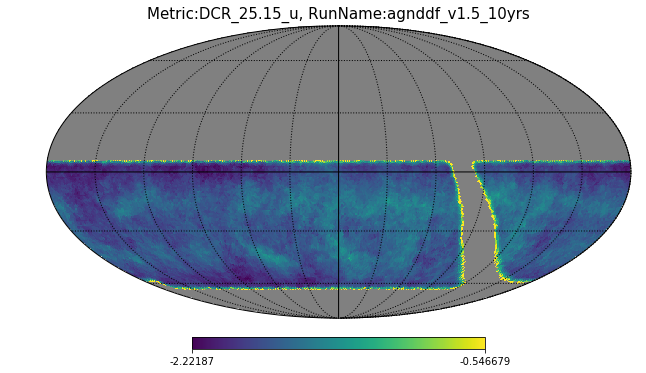

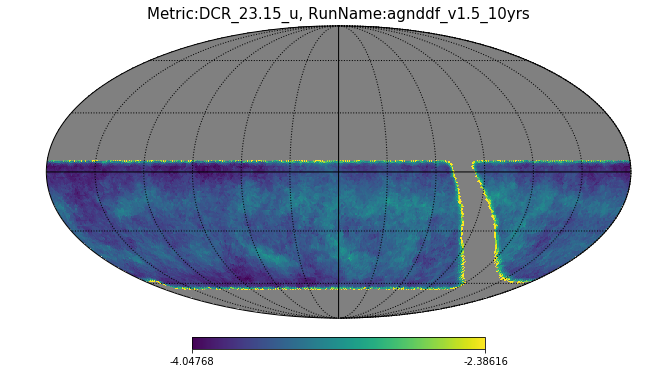

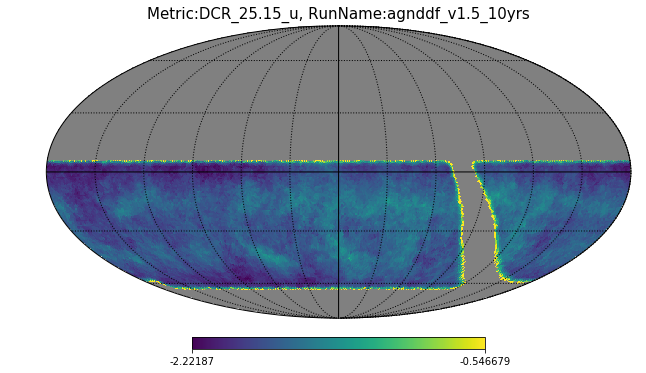

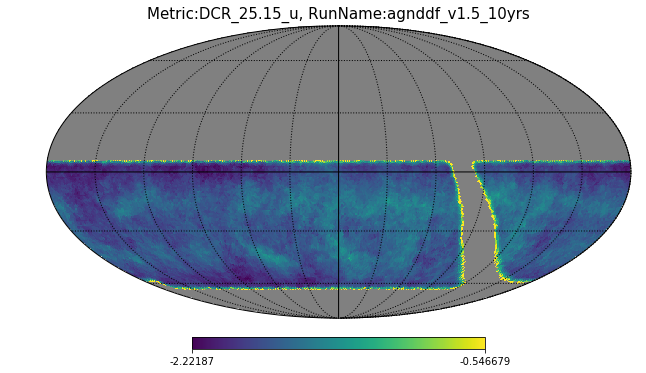

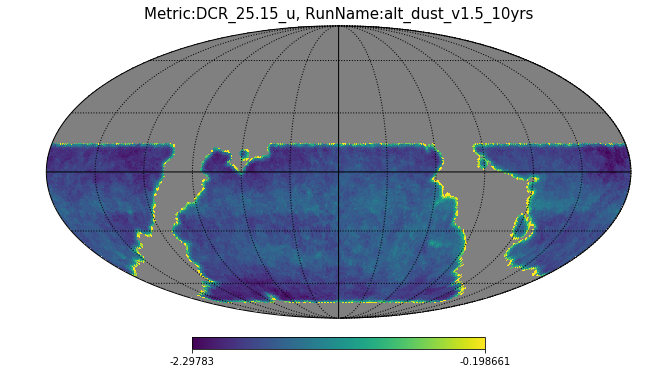

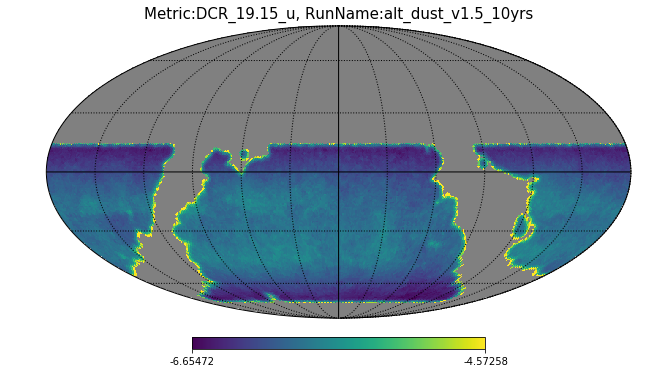

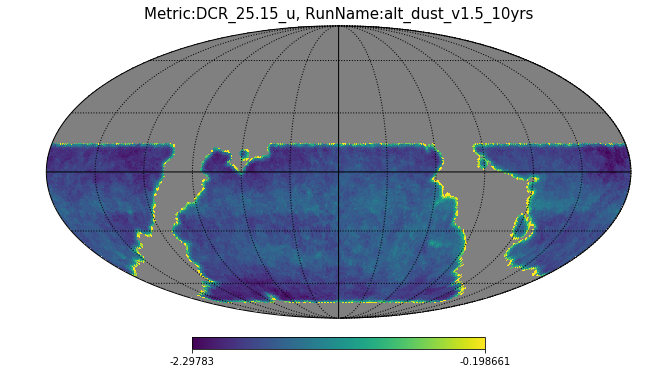

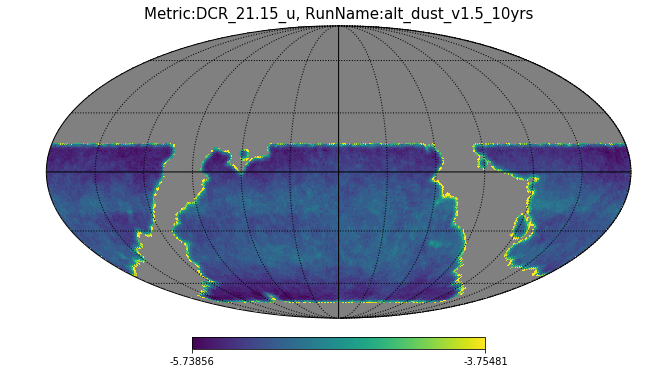

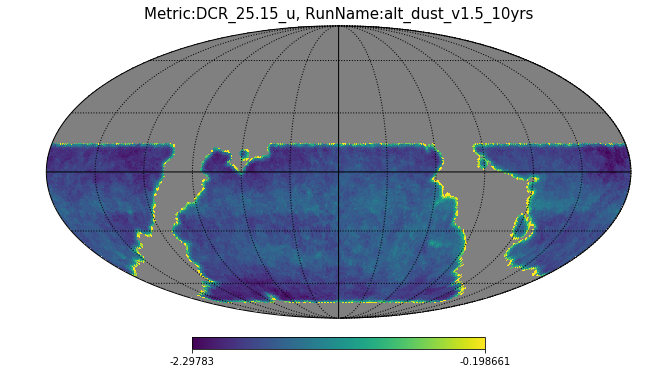

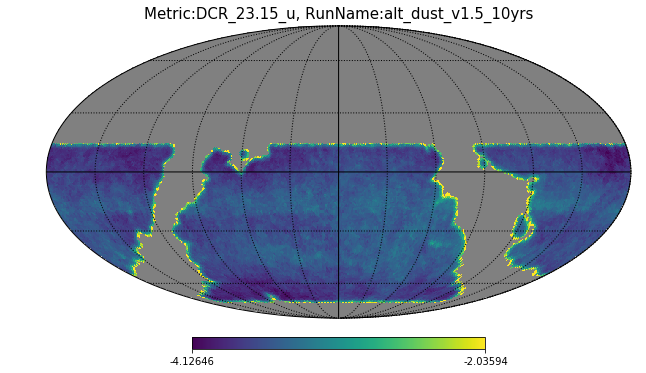

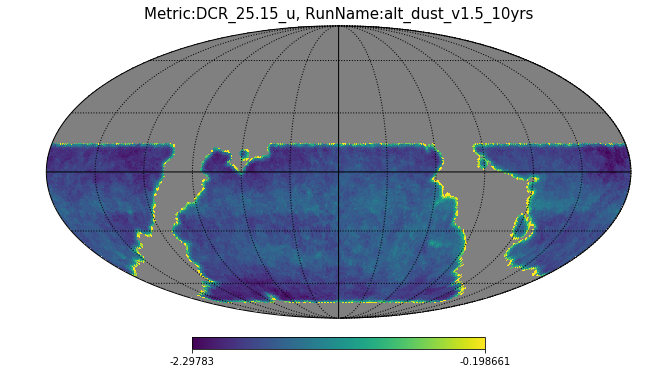

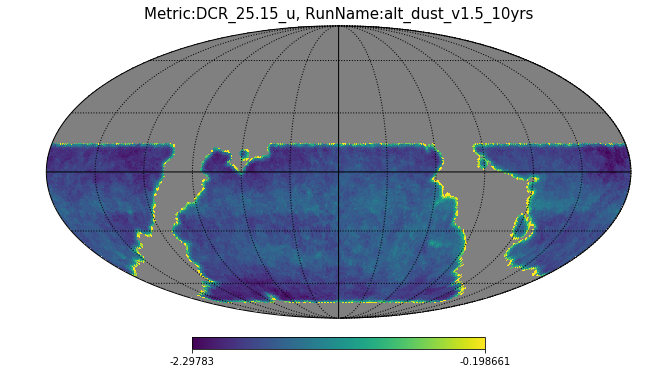

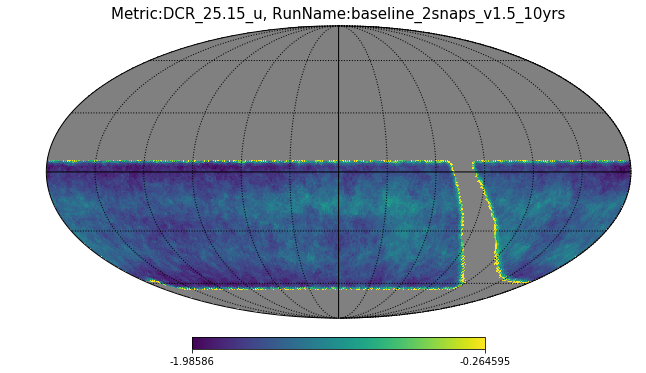

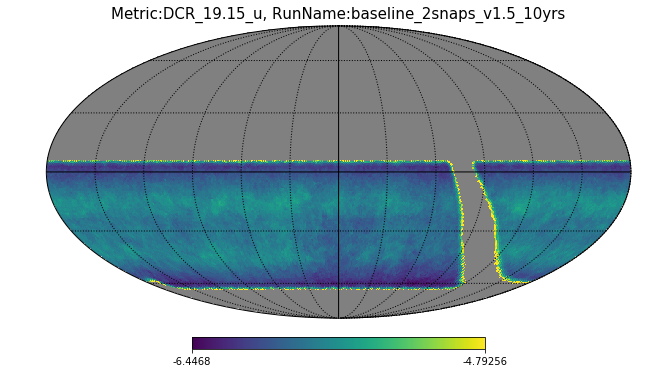

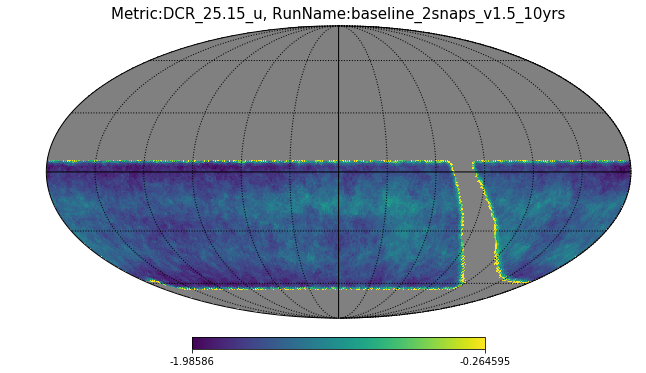

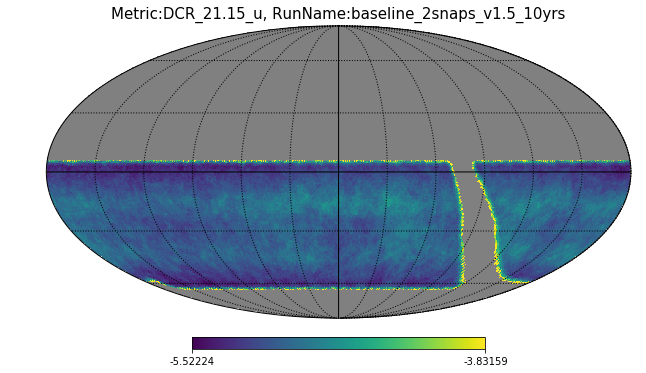

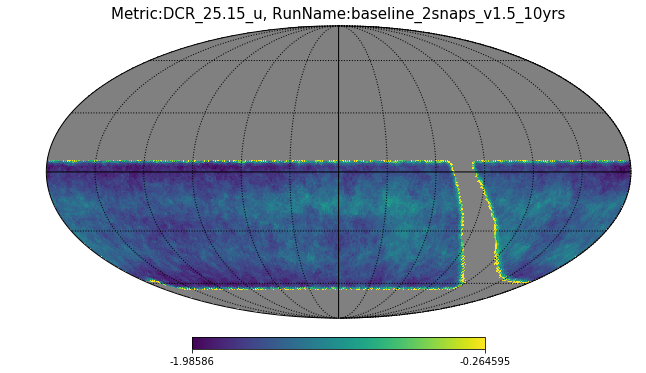

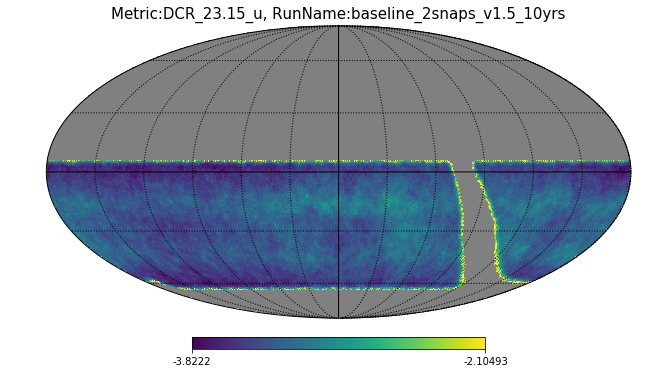

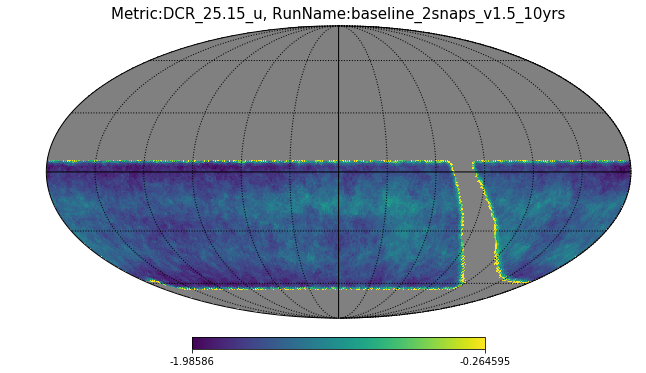

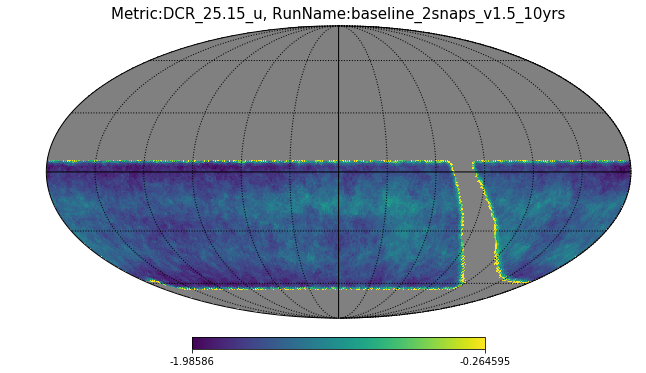

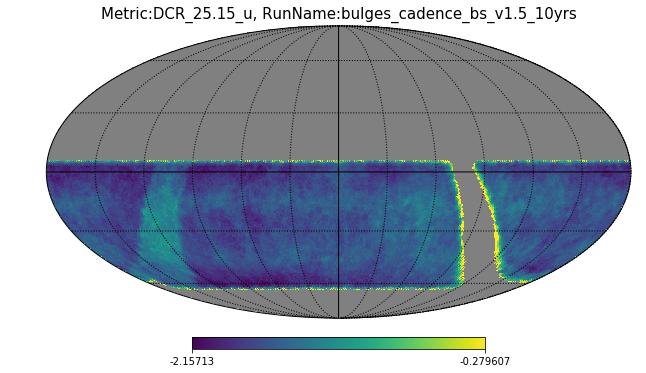

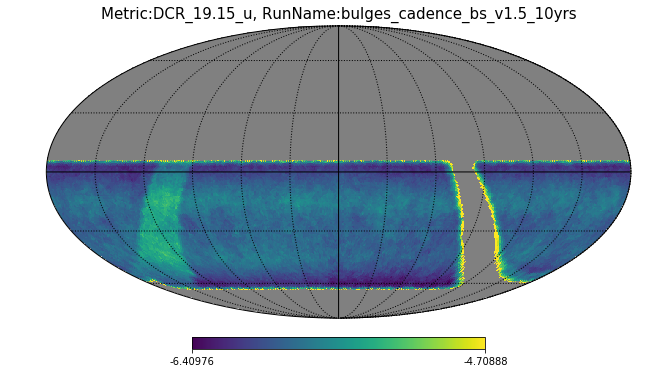

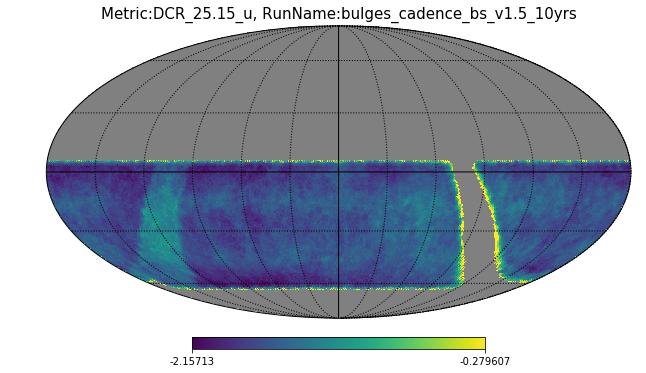

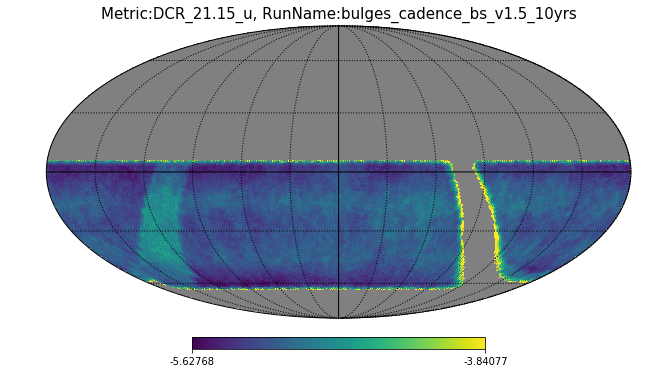

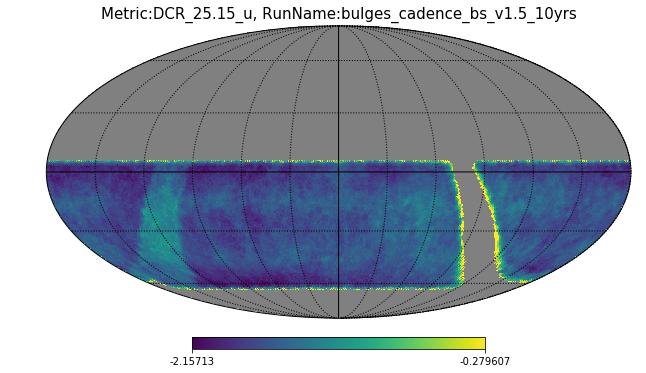

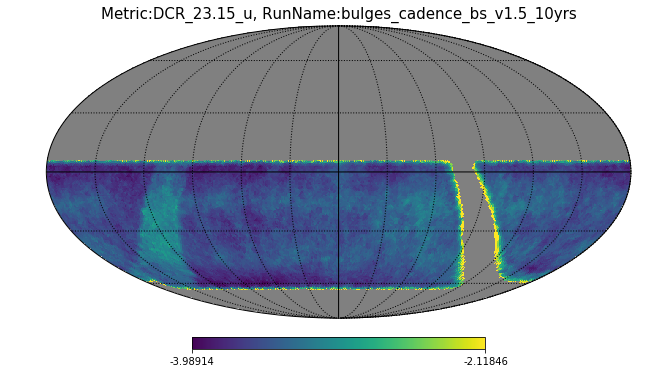

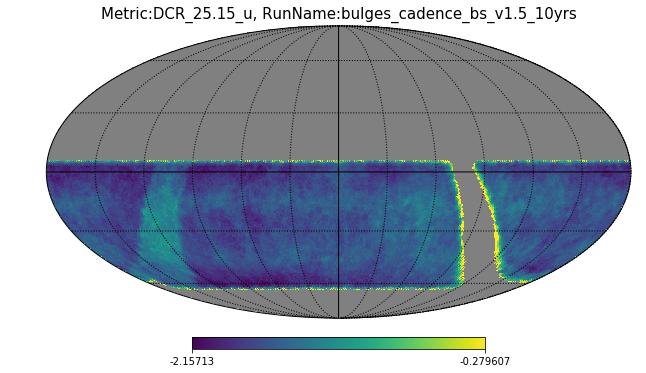

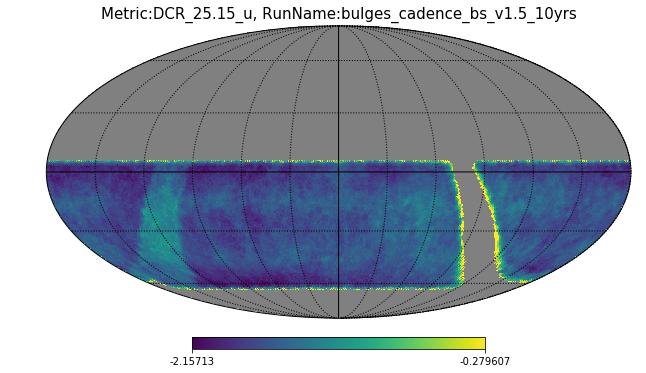

In [80]:
# only plotting first 3 opsims to save space
for k, run in enumerate(resultDbsView):
    if k < 4:
        for i, gMag in enumerate(gMags):

            if i < 4:
                uKey = (i+4, f'DCR_{gMags[i]+0.15}_u')

                # look for the correct combination of metricID and metricName 
                keys = [*bundleDicts[run].keys()]
                metricKeyG = [elem for elem in keys if elem[1] == key[1]][0]
                metricKeyU = [elem for elem in keys if elem[1] == uKey[1]][0]

                plotSky_scale(bundleDicts[run][metricKeyG], np.log)
                plotSky_scale(bundleDicts[run][metricKeyU], np.log)